In [24]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [25]:
data = pd.read_csv(r"CLEAN_DATA/2015-2020_percountry_peryear_final.csv")
country_profiles = pd.read_csv(r"CLEAN_DATA/country_profiles.csv")

In [26]:
# Initialize an empty dictionary to store country profiles
country_profile_dict = {}

# Iterate through each row of the country_profiles_indexed dataframe
for index, row in country_profiles.iterrows():
    # Get the country profile for the current row
    profile = row['Country Profile']
    # Iterate through the list of countries in the current row
    for country_list in row['Country'].split(', '):  # Split the country list by ', '
        # Add the country and its corresponding profile to the dictionary
        country_profile_dict[country_list] = profile

# Map the 'country' column in data dataframe to the 'Country Profile' dictionary
data['Country Profile'] = data['countryname'].map(country_profile_dict)

# Display the updated data dataframe
display(data.head())

,Unnamed: 0.1,Unnamed: 0,countryname,year,rile,stance_positivity_score,gini Coefficient,leading,RILE_stance_score_interaction,Country Profile
0,0,0,Sweden,1970,-10.283625,58.764000,0.299742,left,-604.306940,Country B
1,1,8,Norway,1970,-15.352667,60.142444,0.269873,left,-923.346902,Country B
2,2,17,Denmark,1970,-6.543842,50.180000,0.279386,left,-328.369997,Country B
3,3,36,Finland,1970,-19.870412,50.911235,0.274384,left,-1011.627209,Country B
4,4,53,Iceland,1970,-20.732533,45.709688,0.266170,left,-947.677620,Country A


In [27]:
data.shape

(33, 10)

In [28]:
# one-hot encode country profiles
data = pd.get_dummies(data, columns=['Country Profile'], drop_first=True)
display(data.head())

,Unnamed: 0.1,Unnamed: 0,countryname,year,rile,stance_positivity_score,gini Coefficient,leading,RILE_stance_score_interaction,Country Profile_Country B,Country Profile_Country C,Country Profile_Country D
0,0,0,Sweden,1970,-10.283625,58.764000,0.299742,left,-604.306940,True,False,False
1,1,8,Norway,1970,-15.352667,60.142444,0.269873,left,-923.346902,True,False,False
2,2,17,Denmark,1970,-6.543842,50.180000,0.279386,left,-328.369997,True,False,False
3,3,36,Finland,1970,-19.870412,50.911235,0.274384,left,-1011.627209,True,False,False
4,4,53,Iceland,1970,-20.732533,45.709688,0.266170,left,-947.677620,False,False,False


In [39]:
# linear regression
data.dropna(subset=['gini Coefficient'], inplace=True)
X = data[[
    'rile',
    "stance_positivity_score",
    "RILE_stance_score_interaction",
    "Country Profile_Country B",
    "Country Profile_Country C",
    "Country Profile_Country D"]]
y = data['gini Coefficient']

# initialize model
model = LinearRegression()

# fit model
model.fit(X,y)

# predict gini values
y_pred = model.predict(X)

# Calculate mean squared error
mse = mean_squared_error(y, y_pred)

# Print the coefficients and MSE
print("Intercept:", model.intercept_)
print("Coefficient:", model.coef_[0])
print("Mean Squared Error:", mse)


Intercept: 0.33324511227915027
Coefficient: -0.0015264570353138447
Mean Squared Error: 0.0011960011775370978


In [40]:
data[['Country Profile_Country B', 'Country Profile_Country C', 'Country Profile_Country D']] = data[['Country Profile_Country B', 'Country Profile_Country C', 'Country Profile_Country D']].astype(int)

In [41]:
coefficients = model.coef_
country_profiles = X.columns

# Create a dictionary to store country profiles and their coefficients
profile_coefficients = dict(zip(country_profiles, coefficients))

# Sort the dictionary by coefficient value
sorted_profile_coefficients = sorted(profile_coefficients.items(), key=lambda x: x[1], reverse=True)

# Print 
for profile, coefficient in sorted_profile_coefficients:
    print(f"Country Profile: {profile}, Coefficient: {coefficient}")


Country Profile: Country Profile_Country C, Coefficient: 0.0844961644718167
Country Profile: Country Profile_Country D, Coefficient: 0.031995631043591335
Country Profile: Country Profile_Country B, Coefficient: 0.009947318665670005
Country Profile: RILE_stance_score_interaction, Coefficient: 4.8063497830229884e-05
Country Profile: stance_positivity_score, Coefficient: -0.00045424539439450494
Country Profile: rile, Coefficient: -0.0015264570353138447


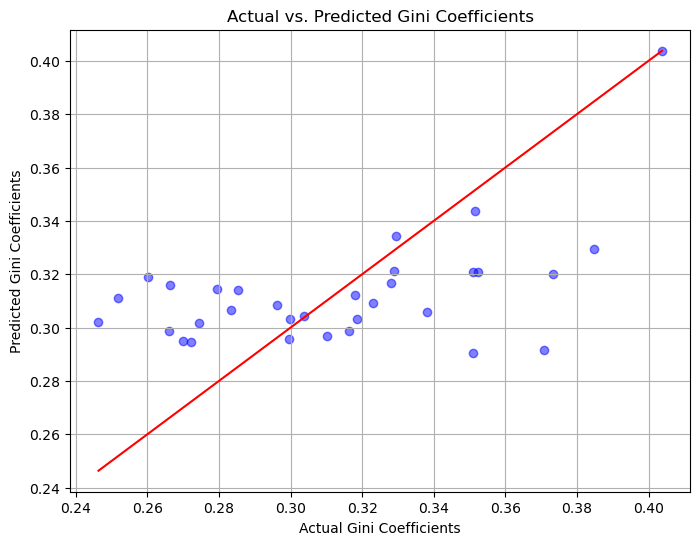

In [42]:
#getting the actual and predicted gini values
y_actual = data['gini Coefficient']

#plotting relationship between actual and predicted values of gini
plt.figure(figsize=(8, 6))
plt.scatter(y_actual, y_pred, color='blue', alpha=0.5)  # Scatter plot of actual vs. predicted
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red')  # Diagonal line for reference
plt.title('Actual vs. Predicted Gini Coefficients')
plt.xlabel('Actual Gini Coefficients')
plt.ylabel('Predicted Gini Coefficients')
plt.grid(True)
plt.show()

### Model with GINI outlier

In [43]:
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = X
y = y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Get the coefficients
coefficients = model.coef_
intercept = model.intercept_

# Combine coefficients into a single array for statsmodels
coefficients_statsmodels = np.concatenate(([intercept], coefficients))

# Predict Gini index values on training and testing sets
predicted_gini_train = model.predict(X_train)
predicted_gini_test = model.predict(X_test)

# Evaluate the model
train_rmse = mean_squared_error(y_train, predicted_gini_train, squared=False)
test_rmse = mean_squared_error(y_test, predicted_gini_test, squared=False)
train_r2 = r2_score(y_train, predicted_gini_train)
test_r2 = r2_score(y_test, predicted_gini_test)

# Add predicted Gini index to the DataFrame
data['Predicted_Gini'] = model.predict(X)

# Use statsmodels to further analyze the regression
X_with_intercept = sm.add_constant(X)  # Add intercept to X for statsmodels
X_with_intercept = np.hstack([np.ones((X.shape[0], 1)), X_with_intercept])
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# Print the summary of the regression results from statsmodels
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       gini Coefficient   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     1.466
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.230
Time:                        08:58:01   Log-Likelihood:                 62.254
No. Observations:                  32   AIC:                            -110.5
Df Residuals:                      25   BIC:                            -100.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1666      0.034      4.941      0.0

### Model without outlier

In [46]:
# Find the index of the data point with the highest Gini coefficient
highest_gini_index = data['gini Coefficient'].idxmax()
highest_gini_index

data_no_outliers = data.drop(highest_gini_index)
data_no_outliers.shape

(31, 13)

In [47]:
# linear regression
data_no_outliers.dropna(subset=['gini Coefficient'], inplace=True)
X = data_no_outliers[[
    'rile',
    "stance_positivity_score",
    "RILE_stance_score_interaction",
    "Country Profile_Country B",
    "Country Profile_Country C",
    "Country Profile_Country D"]]
y = data_no_outliers['gini Coefficient']

# initialize model
model = LinearRegression()

# fit model
model.fit(X,y)

# predict gini values
y_pred = model.predict(X)

# Calculate mean squared error
mse = mean_squared_error(y, y_pred)

# Print the coefficients and MSE
print("Intercept:", model.intercept_)
print("Coefficient:", model.coef_[0])
print("Mean Squared Error:", mse)


Intercept: 0.3332451122791503
Coefficient: -0.0015264570353138466
Mean Squared Error: 0.001234581860683456


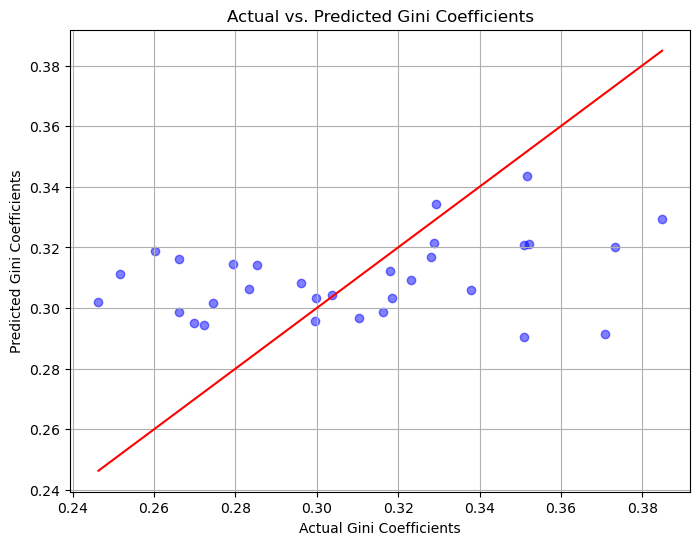

In [49]:
#getting the actual and predicted gini values
y_actual = data_no_outliers['gini Coefficient']

#plotting relationship between actual and predicted values of gini
plt.figure(figsize=(8, 6))
plt.scatter(y_actual, y_pred, color='blue', alpha=0.5)  # Scatter plot of actual vs. predicted
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red')  # Diagonal line for reference
plt.title('Actual vs. Predicted Gini Coefficients')
plt.xlabel('Actual Gini Coefficients')
plt.ylabel('Predicted Gini Coefficients')
plt.grid(True)
plt.show()

In [51]:
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = X
y = y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Get the coefficients
coefficients = model.coef_
intercept = model.intercept_

# Combine coefficients into a single array for statsmodels
coefficients_statsmodels = np.concatenate(([intercept], coefficients))

# Predict Gini index values on training and testing sets
predicted_gini_train = model.predict(X_train)
predicted_gini_test = model.predict(X_test)

# Evaluate the model
train_rmse = mean_squared_error(y_train, predicted_gini_train, squared=False)
test_rmse = mean_squared_error(y_test, predicted_gini_test, squared=False)
train_r2 = r2_score(y_train, predicted_gini_train)
test_r2 = r2_score(y_test, predicted_gini_test)

# Add predicted Gini index to the DataFrame
data_no_outliers['Predicted_Gini'] = model.predict(X)

# Use statsmodels to further analyze the regression
X_with_intercept = sm.add_constant(X)  # Add intercept to X for statsmodels
X_with_intercept = np.hstack([np.ones((X.shape[0], 1)), X_with_intercept])
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# Print the summary of the regression results from statsmodels
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       gini Coefficient   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                 -0.064
Method:                 Least Squares   F-statistic:                    0.6374
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.673
Time:                        09:32:40   Log-Likelihood:                 59.817
No. Observations:                  31   AIC:                            -107.6
Df Residuals:                      25   BIC:                            -99.03
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1666      0.034      4.941      0.0

c:\Users\sebgr\.conda\envs\Uni\Lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


### Try logistic regression now